In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from models import Model

/Users/I551393/Library/Caches/pypoetry/virtualenvs/tsf-ss25-timegpt-9SjHUXw4-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('../../transformed_data/cleaned_wti_oil.csv')
df['ts'] = pd.to_datetime(df['ts'])
df = df.sort_values('ts').reset_index(drop=True)
df.rename(columns={"series_value": "y"}, inplace=True)
print("Length of the df: ", len(df))

Length of the df:  331633


# Data Understanding

99490


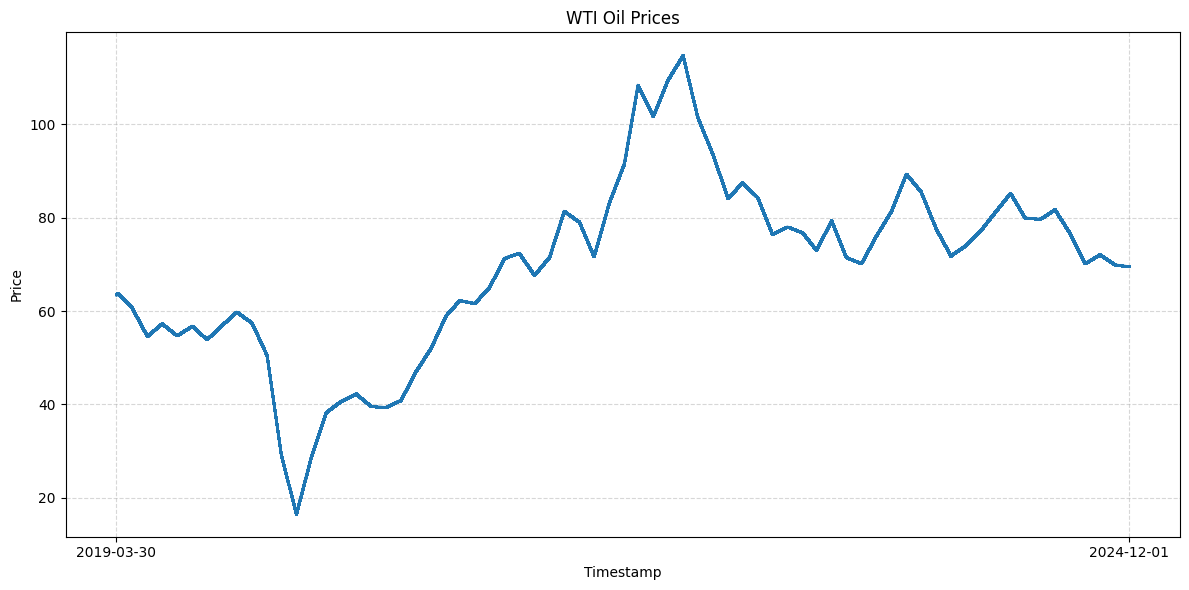

In [26]:
df_short = df[int(len(df) * 0.7):]
print(len(df_short))

start = df_short['ts'].min()
end = df_short['ts'].max()


plt.figure(figsize=(12, 6))
plt.plot(df_short['ts'], df_short['y'], marker='o', markersize=1)

# Start and End-Ticks
plt.xticks([start, end], [start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')])

plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('WTI Oil Prices')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [18]:
# shortening the dataset
size = 200000 # length of the training dataset

df_recent = df.tail(size).copy()
train_ratio = 0.8
split_idx   = int(len(df_recent) * train_ratio)

df_train = df_recent.iloc[:split_idx].copy().reset_index(drop=True)
df_test  = df_recent.iloc[split_idx:].copy().reset_index(drop=True)

df_recent.head()

,ts,y
131633,2013-07-05 08:30:00,104.938033
131634,2013-07-05 09:00:00,104.939311
131635,2013-07-05 09:30:00,104.940589
131636,2013-07-05 10:00:00,104.941867
131637,2013-07-05 10:30:00,104.943145


In [6]:
model = Model(df=df_recent)

✅ All timestamps are in a 30-minute grid


# Baseline

# ARIMA

In [7]:
arima_result = model.auto_arima()
arima_result.head()

Starting ARIMA Training...

ARIMA Training Duration:  94.99102592468262


,ts,yhat
0,2024-11-22 16:30:00,69.691459
1,2024-11-22 17:00:00,69.691175
2,2024-11-22 17:30:00,69.690891
3,2024-11-22 18:00:00,69.690607
4,2024-11-22 18:30:00,69.690323


# LSTM

# Prophet

In [8]:
# Forecast
prophet_result = model.prophet()
prophet_result.head()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmp9w90ajzs/ilbai2mf.json
DEBUG:cmdstanpy:input tempfile: /var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmp9w90ajzs/pmmqaejv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/I551393/Library/Caches/pypoetry/virtualenvs/tsf-ss25-timegpt-9SjHUXw4-py3.10/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2828', 'data', 'file=/var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmp9w90ajzs/ilbai2mf.json', 'init=/var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmp9w90ajzs/pmmqaejv.json', 'output', 'file=/var/folders/5s/24kwdb7x22qbn_jcn813nryw0000gn/T/tmp9w90ajzs/prophet_modeloeft2mm9/prophet_model-20250702181309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:13:09 - cmdstanpy - INFO - Chain [1] star

Starting Prophet Training...



18:13:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Training duration:  1.3903090953826904


,ts,yhat
0,2024-11-22 16:30:00,69.691553
1,2024-11-22 17:00:00,69.691269
2,2024-11-22 17:30:00,69.690986
3,2024-11-22 18:00:00,69.690704
4,2024-11-22 18:30:00,69.690422


# TimesFM

# TimeGPT

In [9]:
model = Model(df_recent)
nixtla_result = model.time_gpt()
nixtla_result.head()

✅ All timestamps are in a 30-minute grid


INFO:nixtla.nixtla_client:Happy Forecasting! :)
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...


True
Starting TimeGPT Training...



INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Nixtla Prediction Time:  1.2913360595703125


,ts,yhat
0,2024-11-22 16:30:00,69.691605
1,2024-11-22 17:00:00,69.691440
2,2024-11-22 17:30:00,69.691280
3,2024-11-22 18:00:00,69.690990
4,2024-11-22 18:30:00,69.690780


# Summary

## Metrics

In [10]:
# Calculate metrics for all models
models_metrics = {}

# ARIMA metrics
arima_mae = mean_absolute_error(df_test['y'], arima_result['yhat'])
arima_mape = mean_absolute_percentage_error(df_test['y'], arima_result['yhat'])
arima_mse = mean_squared_error(df_test['y'], arima_result['yhat'])
models_metrics['ARIMA'] = {'MAE': arima_mae, 'MAPE': arima_mape, 'MSE': arima_mse}

# Prophet metrics
prophet_mae = mean_absolute_error(df_test['y'], prophet_result['yhat'])
prophet_mape = mean_absolute_percentage_error(df_test['y'], prophet_result['yhat'])
prophet_mse = mean_squared_error(df_test['y'], prophet_result['yhat'])
models_metrics['Prophet'] = {'MAE': prophet_mae, 'MAPE': prophet_mape, 'MSE': prophet_mse}

# TimeGPT metrics
nixtla_mae = mean_absolute_error(df_test['y'], nixtla_result['yhat'])
nixtla_mape = mean_absolute_percentage_error(df_test['y'], nixtla_result['yhat'])
nixtla_mse = mean_squared_error(df_test['y'], nixtla_result['yhat'])
models_metrics['TimeGPT'] = {'MAE': nixtla_mae, 'MAPE': nixtla_mape, 'MSE': nixtla_mse}

# Display results
metrics_df = pd.DataFrame(models_metrics).T
print("Model Performance Metrics:")
print(metrics_df.round(4))

Model Performance Metrics:
            MAE    MAPE     MSE
ARIMA    0.0000  0.0000  0.0000
Prophet  0.0001  0.0000  0.0000
TimeGPT  0.0601  0.0009  0.0047


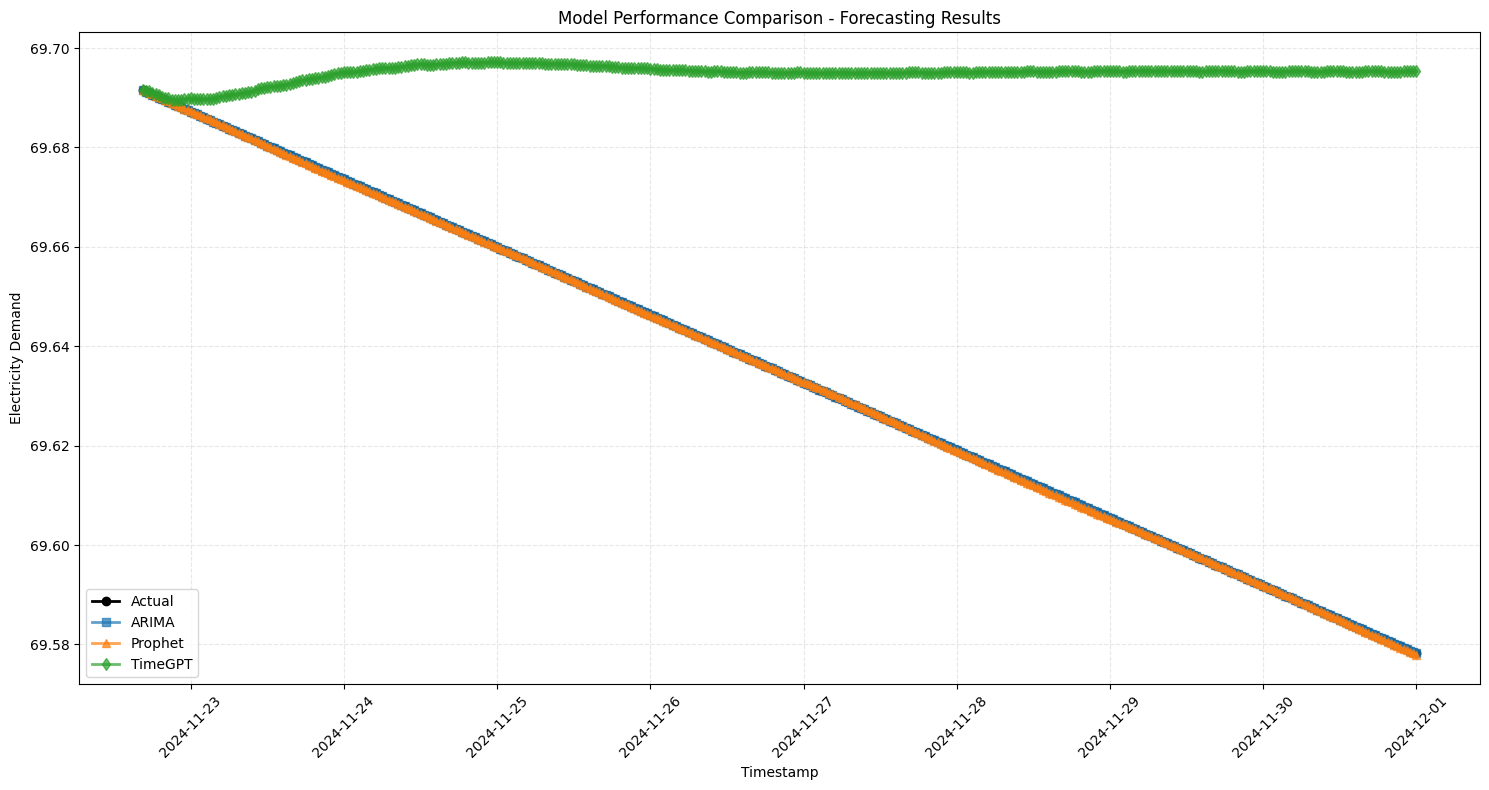

In [11]:
plt.figure(figsize=(15, 8))

# Plot actual values
plt.plot(df_test['ts'], df_test['y'], label='Actual', marker='o', linewidth=2, color='black')

# Plot ARIMA predictions (filter out NaN values)
arima_valid = arima_result.dropna()
plt.plot(arima_valid['ts'], arima_valid['yhat'], label='ARIMA', marker='s', linewidth=2, alpha=0.7)

# Plot Prophet predictions
plt.plot(prophet_result['ts'], prophet_result['yhat'], label='Prophet', marker='^', linewidth=2, alpha=0.7)

# Plot TimeGPT predictions
plt.plot(nixtla_result['ts'], nixtla_result['yhat'], label='TimeGPT', marker='d', linewidth=2, alpha=0.7)

plt.xlabel('Timestamp')
plt.ylabel('Electricity Demand')
plt.title('Model Performance Comparison - Forecasting Results')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()